<a href="https://colab.research.google.com/github/BrentMaples/cs426_final_project/blob/main/Athlete_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brent Maples and Coleman Oates

If Using Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col, expr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Datasets

In [ ]:
daily_load_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/daily_load.csv") #
weekly_load_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/weekly_load.csv")
monotony_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/monotony.csv")
strain_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/strain.csv")
acute_chronic_workload_ratio_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/acwr.csv")
acute_training_load_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/atl.csv")
chronic_training_load_28_days_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/ctl28.csv")
chronic_training_load_42_days_dataset = ("/content/drive/MyDrive/cs426/subjective/training-load/ctl42.csv")
fatigue_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/fatigue.csv")
mood_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/mood.csv")
readiness_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/readiness.csv")
sleep_duration_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/sleep_duration.csv")
sleep_quality_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/sleep_quality.csv")
soreness_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/soreness.csv")
stress_dataset = ("/content/drive/MyDrive/cs426/subjective/wellness/stress.csv")

In [ ]:
spark = SparkSession.builder.appName("Athlete Analysis").getOrCreate()
sc = spark.sparkContext

### Visualize the average score of each wellness category (self-reported) for each player

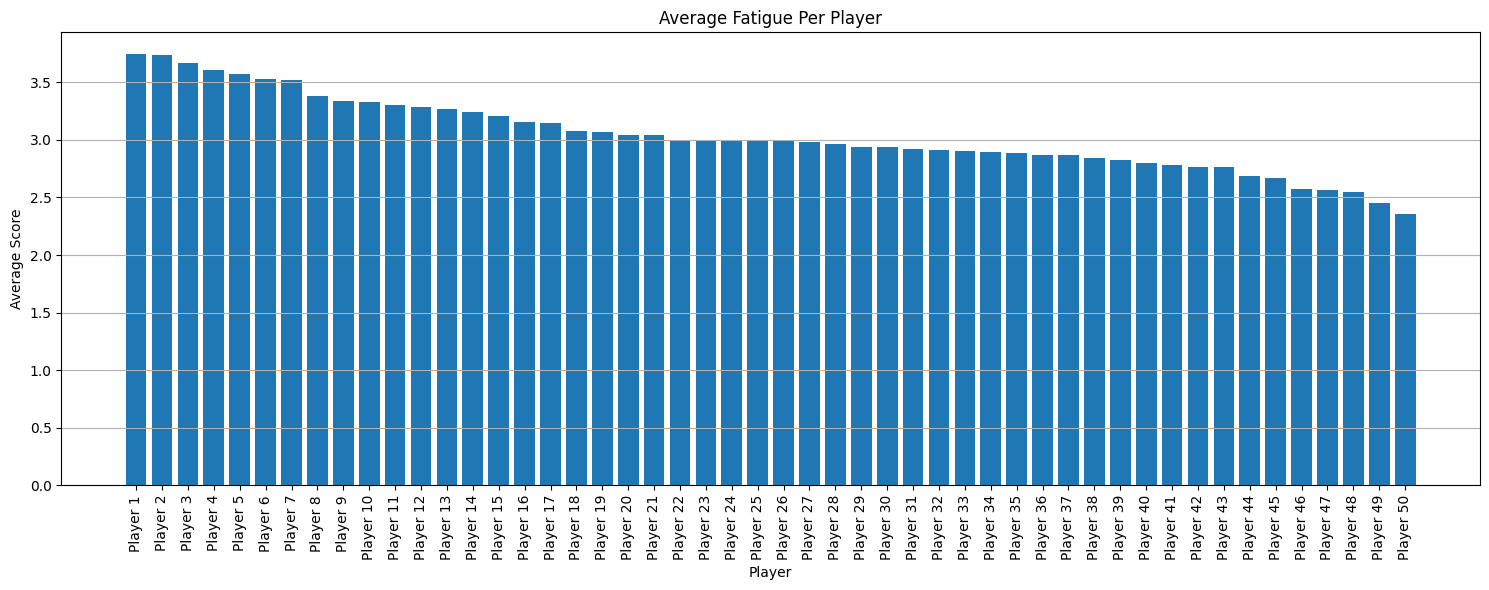

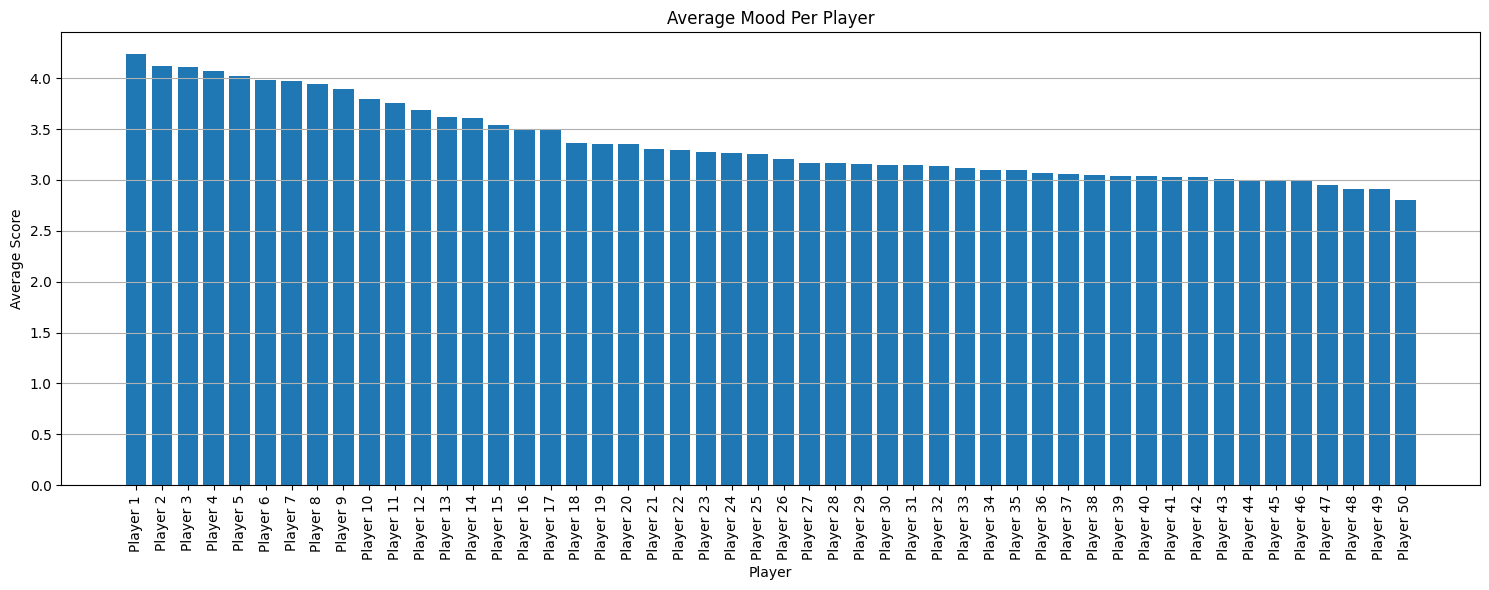

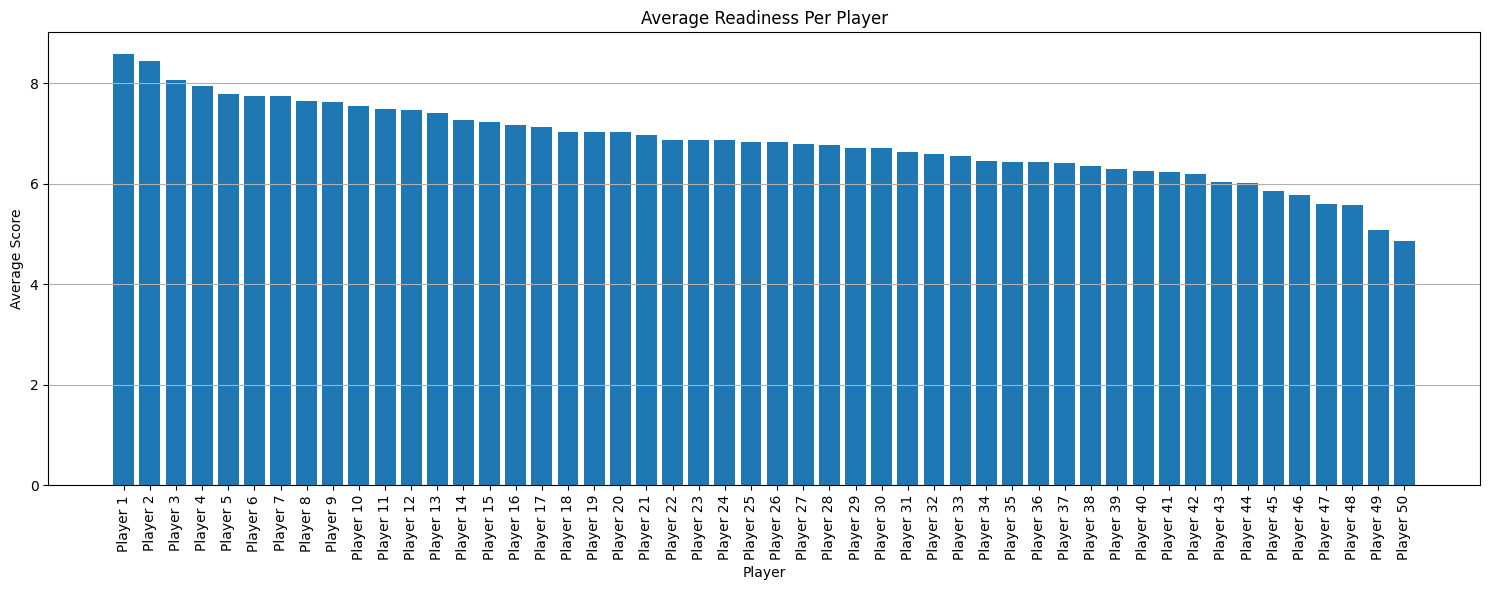

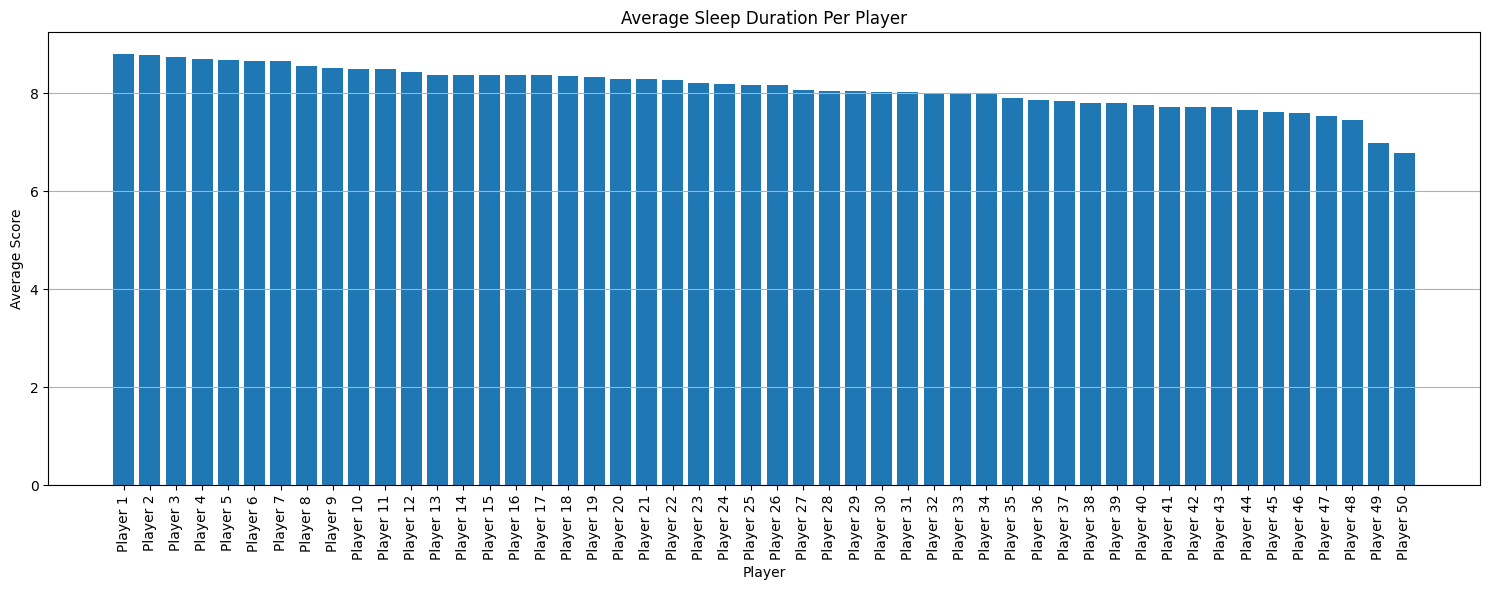

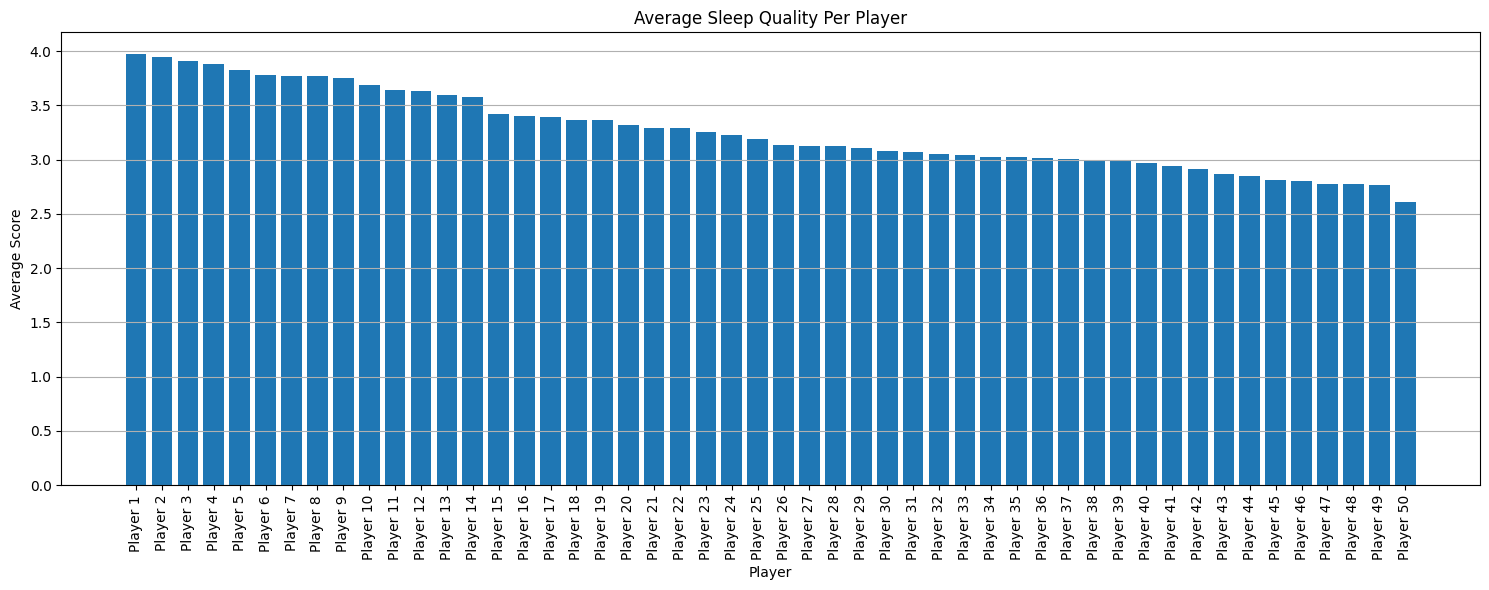

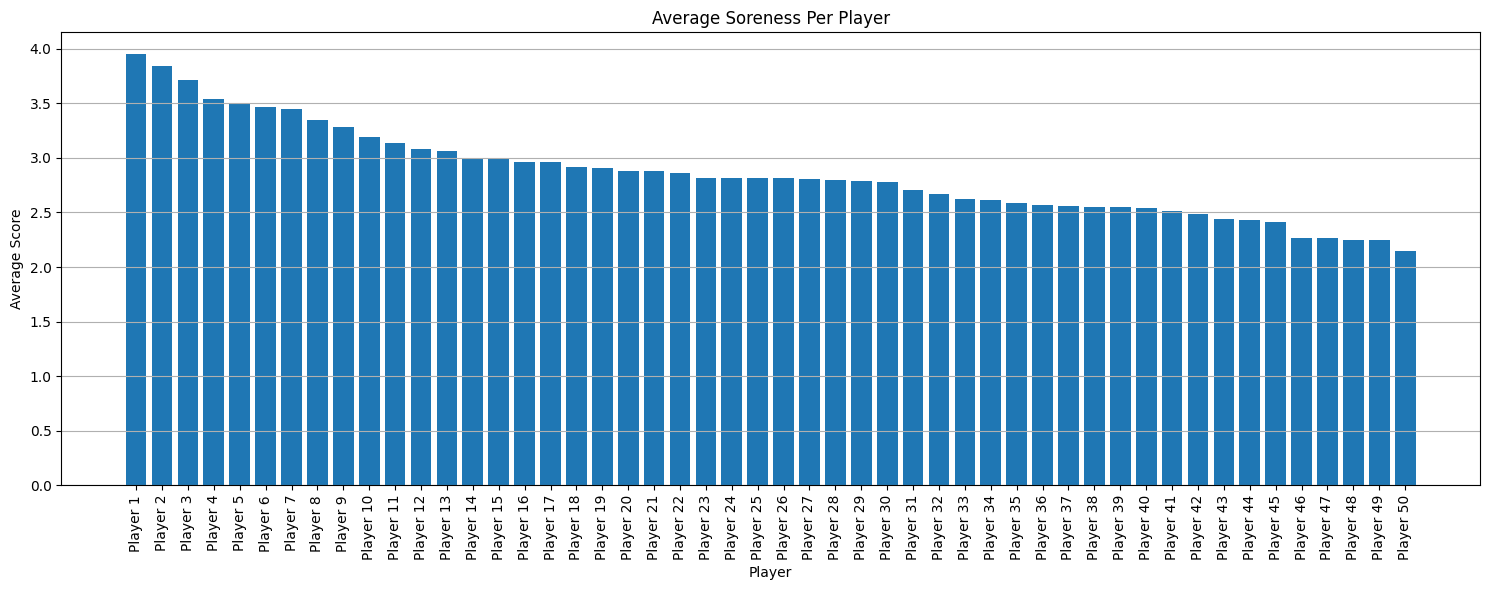

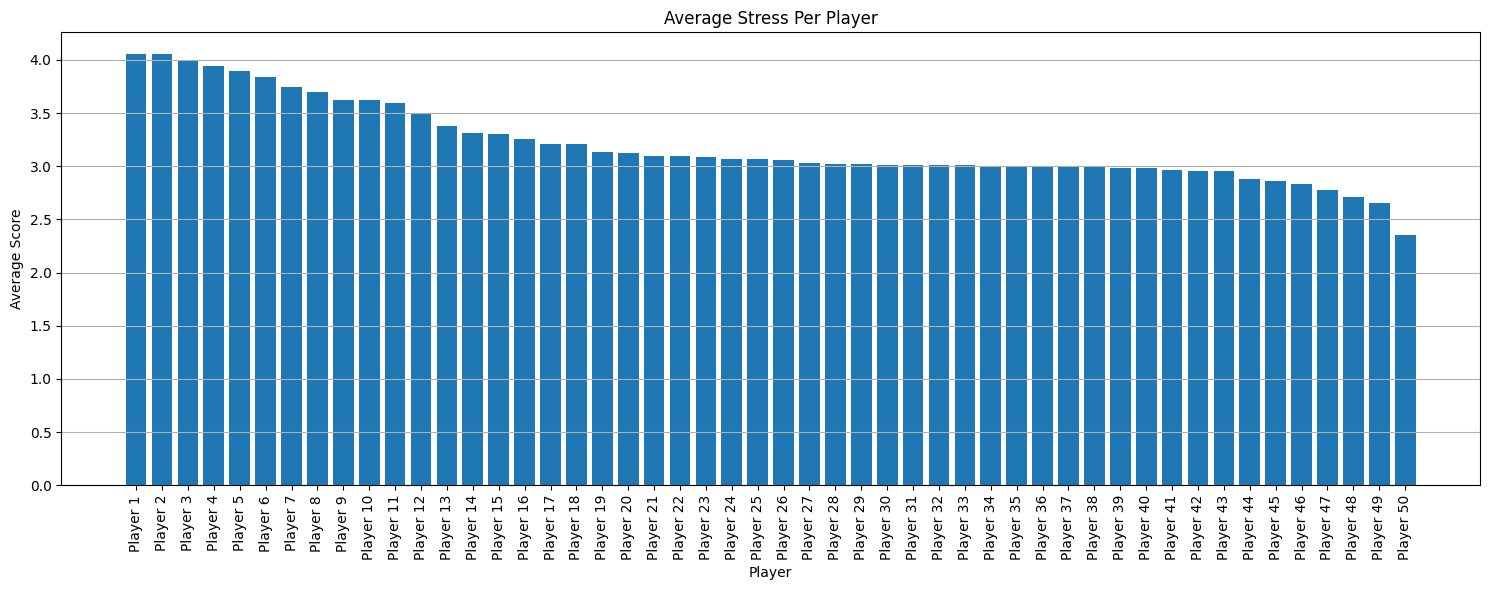

In [ ]:
def process_and_plot(csv_path, title):
    # Load and rename
    df = spark.read.option("header", "true").csv(csv_path)
    df = df.withColumnRenamed(df.columns[0], "date")
    df = df.withColumn("date", to_date("date", "yyyy-MM-dd"))

    # Melt
    player_columns = [col_name for col_name in df.columns if col_name != "date"]
    expr_str = ", ".join([f"'{p}', `{p}`" for p in player_columns])
    melted_df = df.selectExpr("date", f"stack({len(player_columns)}, {expr_str}) as (player_id, score)")

    # Clean
    clean_df = melted_df.filter(col("score").isNotNull())
    clean_df = clean_df.withColumn("score", col("score").cast("float"))

    # Average
    avg_df = clean_df.groupBy("player_id").avg("score").withColumnRenamed("avg(score)", "avg_score")
    avg_pd = avg_df.toPandas().sort_values(by="avg_score", ascending=False)

    # Rename players for readability
    player_mapping = {pid: f"Player {i+1}" for i, pid in enumerate(avg_pd["player_id"])}
    avg_pd["player_label"] = avg_pd["player_id"].map(player_mapping)

    # Plot
    plt.figure(figsize=(15, 6))
    plt.bar(avg_pd["player_label"], avg_pd["avg_score"])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Player")
    plt.ylabel("Average Score")
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

    return clean_df

# Process and plot each file
fatigue = process_and_plot(fatigue_dataset, "Average Fatigue Per Player")
mood = process_and_plot(mood_dataset, "Average Mood Per Player")
readiness = process_and_plot(readiness_dataset, "Average Readiness Per Player")
sleep_duration = process_and_plot(sleep_duration_dataset, "Average Sleep Duration Per Player")
sleep_quality = process_and_plot(sleep_quality_dataset, "Average Sleep Quality Per Player")
soreness = process_and_plot(soreness_dataset, "Average Soreness Per Player")
stress = process_and_plot(stress_dataset, "Average Stress Per Player")

### Visualize the average non-subjective wellness data for players and the combined distribution of data

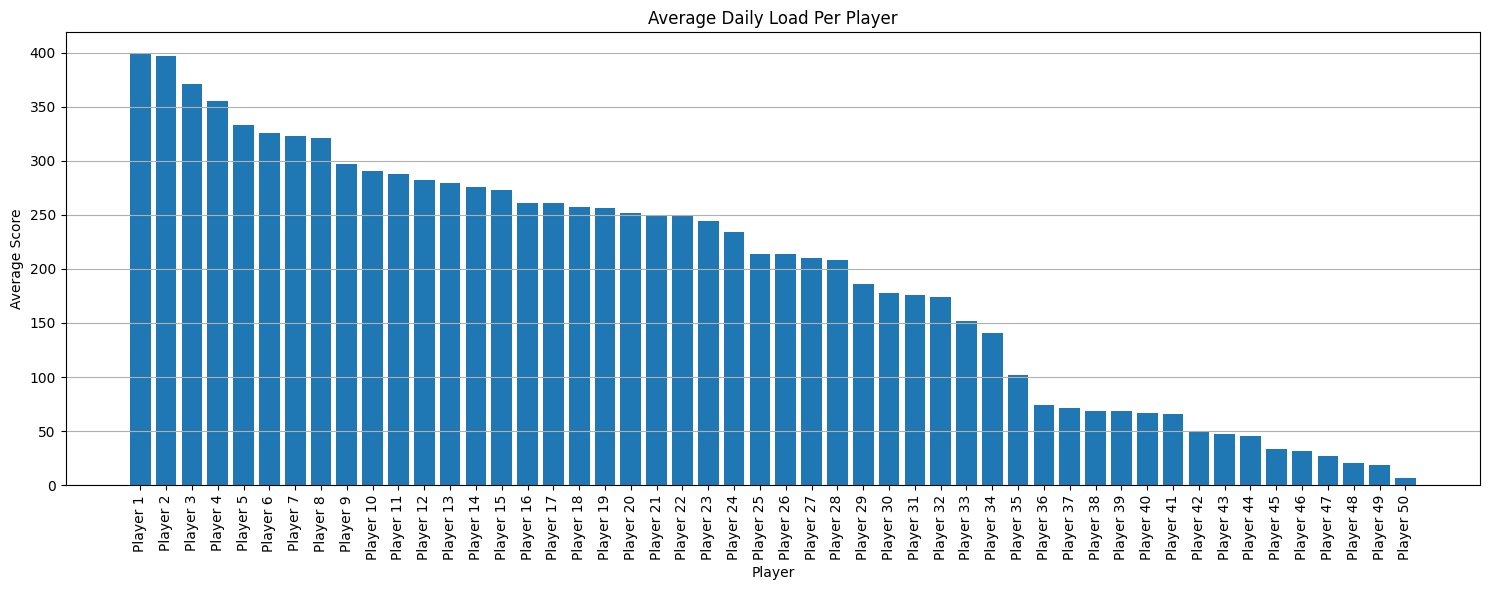

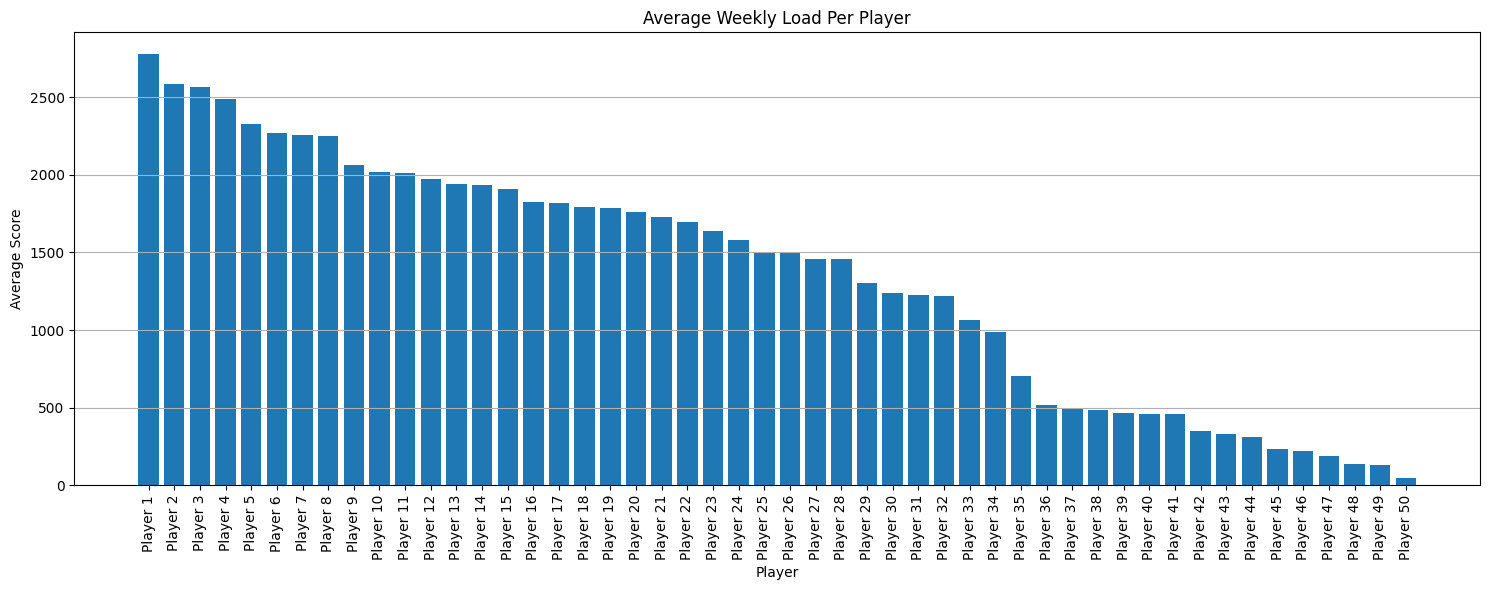

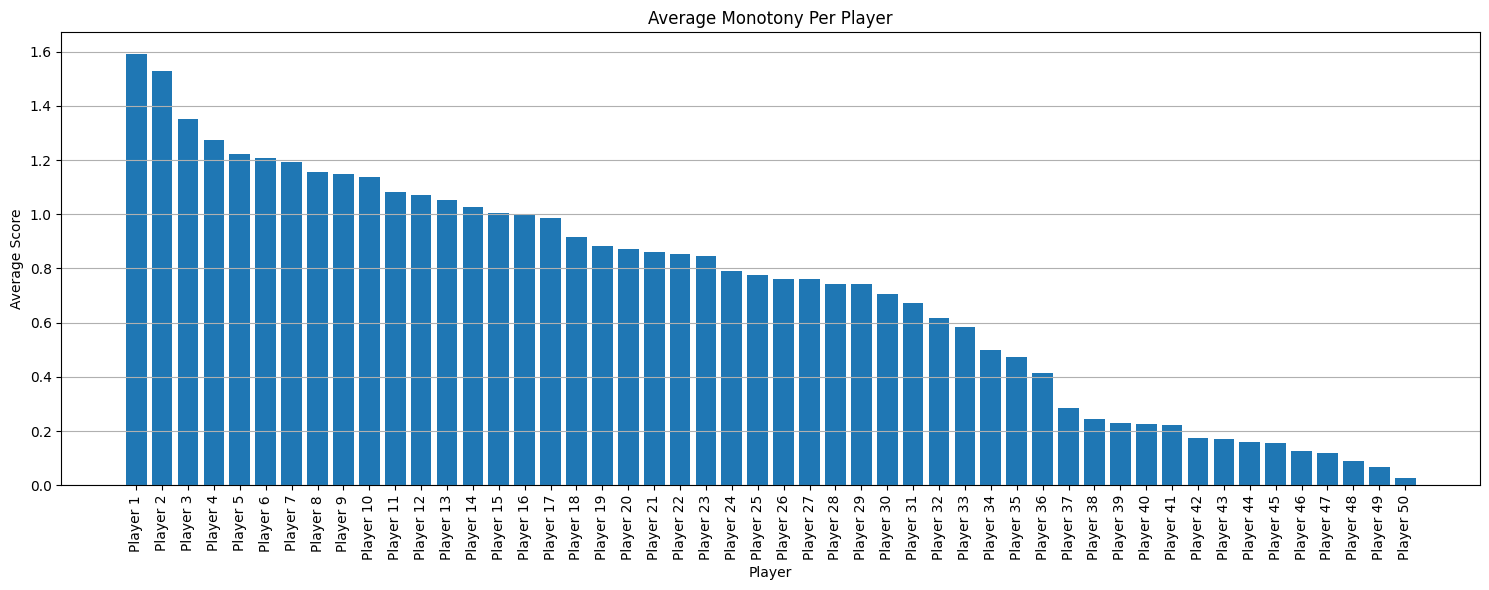

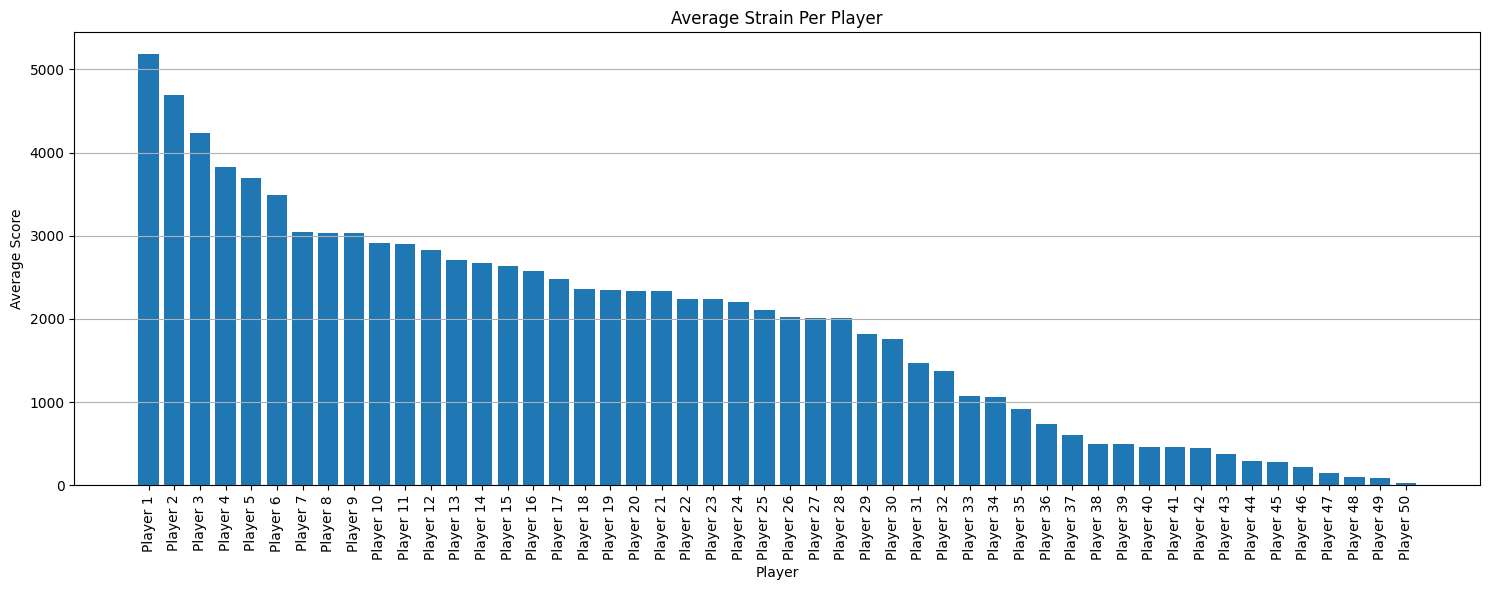

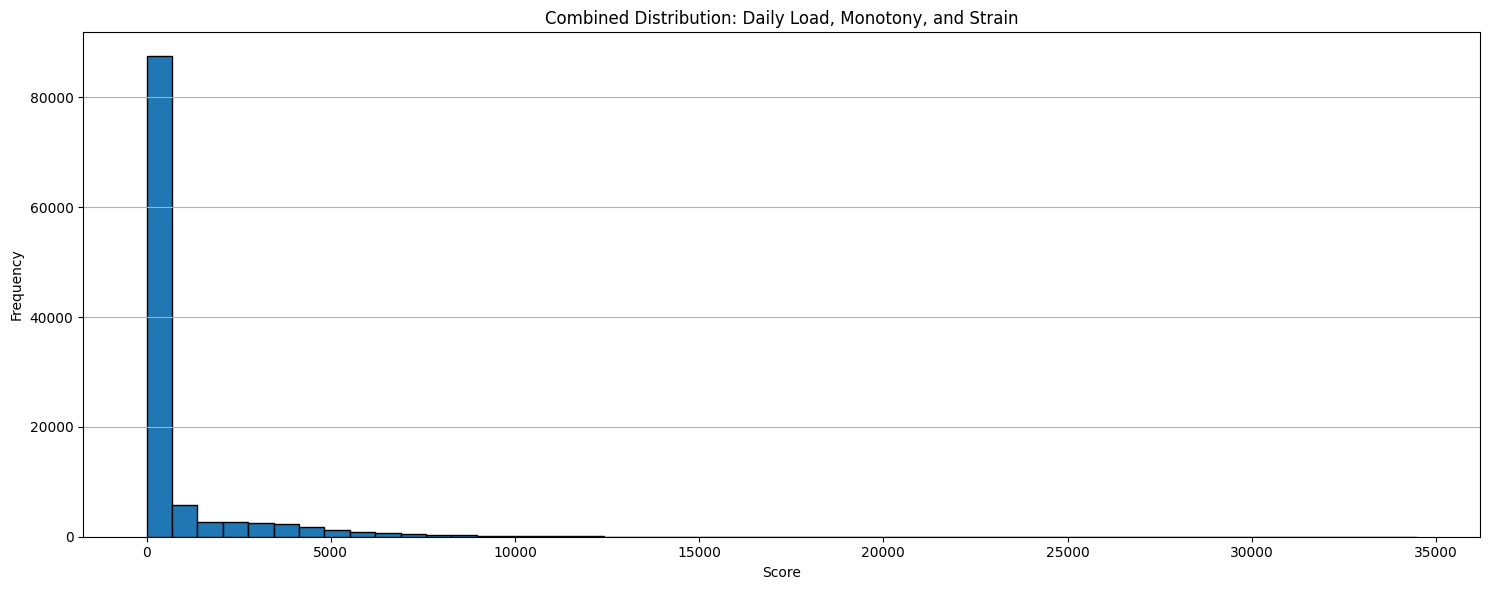

In [ ]:
def process_and_plot(csv_path, title):
    # Load and rename
    df = spark.read.option("header", "true").csv(csv_path)
    df = df.withColumnRenamed(df.columns[0], "date")
    df = df.withColumn("date", to_date("date", "yyyy-MM-dd"))

    # Melt
    player_columns = [col_name for col_name in df.columns if col_name != "date"]
    expr_str = ", ".join([f"'{p}', `{p}`" for p in player_columns])
    melted_df = df.selectExpr("date", f"stack({len(player_columns)}, {expr_str}) as (player_id, score)")

    # Clean
    clean_df = melted_df.filter(col("score").isNotNull())
    clean_df = clean_df.withColumn("score", col("score").cast("float"))

    # Average
    avg_df = clean_df.groupBy("player_id").avg("score").withColumnRenamed("avg(score)", "avg_score")
    avg_pd = avg_df.toPandas().sort_values(by="avg_score", ascending=False)

    # Rename players for readability
    player_mapping = {pid: f"Player {i+1}" for i, pid in enumerate(avg_pd["player_id"])}
    avg_pd["player_label"] = avg_pd["player_id"].map(player_mapping)

    # Plot
    plt.figure(figsize=(15, 6))
    plt.bar(avg_pd["player_label"], avg_pd["avg_score"])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Player")
    plt.ylabel("Average Score")
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

    return clean_df

# Process and plot each file
daily_df = process_and_plot(daily_load_dataset, "Average Daily Load Per Player")
weekly_df = process_and_plot(weekly_load_dataset, "Average Weekly Load Per Player")
monotony_df = process_and_plot(monotony_dataset, "Average Monotony Per Player")
strain_df = process_and_plot(strain_dataset, "Average Strain Per Player")

# For the combined plot (NO players)
def combine_and_plot(*dfs, title):
    from functools import reduce
    combined_df = reduce(lambda df1, df2: df1.unionByName(df2), dfs)

    combined_pd = combined_df.toPandas()
    combined_pd = combined_pd.dropna(subset=["score"])

    plt.figure(figsize=(15, 6))
    plt.hist(combined_pd["score"], bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

combine_and_plot(daily_df, monotony_df, strain_df, title="Combined Distribution: Daily Load, Monotony, and Strain")

Code Using Learned In-Class Methods

sRPE - The workload for a single session based on the session duration and the reported RPE <br>
Daily Load - Sum of sRPE for the day <br>
Weekly Load - Sum of sRPE for the last 7 days <br>
Acute Training Load - The current level of fatigue (average sRPE over the last 7 days) <br>
Chronic Training Load - The cumulative training dose that builds up over a longer period of time (average sRPE over the last 28 or 42 days) <br>
Acute Chronic Workload Ratio - An indication of whether an athlete is in a well-prepared state, or at an increased risk of getting injured (ATL divided by CTL) <br>
Monotony - Training variation across the last 7 days (average sRPE over the last 7 days divided by the standard deviation (SD)) <br>
Strain - Overall training stress from the last 7 days (total weekly sRPE multiplied with Monotony) <br>




First we want to analyze the correlation between monotony and strain.

In [ ]:
def process_for_line_plot_pandas(csv_path):
    df = spark.read.option("header", "true").csv(csv_path)
    df = df.withColumnRenamed(df.columns[0], "date")
    df = df.withColumn("date", to_date("date", "yyyy-MM-dd"))

    player_columns = [col_name for col_name in df.columns if col_name != "date"]
    expr_str = ", ".join([f"'{p}', `{p}`" for p in player_columns])
    melted_df = df.selectExpr("date", f"stack({len(player_columns)}, {expr_str}) as (player_id, score)")
    melted_df = melted_df.filter(col("score").isNotNull()).withColumn("score", col("score").cast("float"))

    return melted_df.toPandas().sort_values(by="date")

def bar_compare(df1, df2=None, label1="Metric 1", label2="Metric 2", title="Comparison Plot"):
    def avg_score(df, label):
        return (
            df.groupby("player_id")["score"]
            .mean()
            .reset_index()
            .rename(columns={"score": label})
        )

    df1_avg = avg_score(df1, label1)
    df1_avg["player_label"] = df1_avg["player_id"].map(player_mapping)

    if df2 is not None:
        df2_avg = avg_score(df2, label2)
        merged = pd.merge(df1_avg, df2_avg, on="player_id")
        merged["player_label"] = merged["player_id"].map(player_mapping)

        x = range(len(merged))
        plt.figure(figsize=(15, 6))
        plt.bar(x, merged[label1], width=0.4, label=label1, align="center")
        plt.bar([i + 0.4 for i in x], merged[label2], width=0.4, label=label2, align="center")
        plt.xticks([i + 0.2 for i in x], merged["player_label"], rotation=90)
    else:
        x = range(len(df1_avg))
        plt.figure(figsize=(15, 6))
        plt.bar(x, df1_avg[label1], width=0.6, label=label1)
        plt.xticks(x, df1_avg["player_label"], rotation=90)

    plt.title(title)
    plt.xlabel("Player")
    plt.ylabel("Average Score")
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
strain_pd = process_for_line_plot_pandas(strain_dataset)
daily_pd = process_for_line_plot_pandas(daily_load_dataset)
weekly_pd = process_for_line_plot_pandas(weekly_load_dataset)
acwr_pd = process_for_line_plot_pandas(acute_chronic_workload_ratio_dataset)
actl_pd = process_for_line_plot_pandas(acute_training_load_dataset)
ctl_pd = process_for_line_plot_pandas(chronic_training_load_28_days_dataset)

# Generate consistent player labels
unique_players = sorted(set(strain_pd["player_id"]) |
                        set(weekly_pd["player_id"]) |
                        set(acwr_pd["player_id"]) |
                        set(actl_pd["player_id"]) |
                        set(ctl_pd["player_id"]))

player_mapping = {pid: f"Player {i+1}" for i, pid in enumerate(unique_players)}

# Apply mapping to all DataFrames
for df in [strain_pd, weekly_pd, acwr_pd, actl_pd, ctl_pd]:
    df["player_label"] = df["player_id"].map(player_mapping)


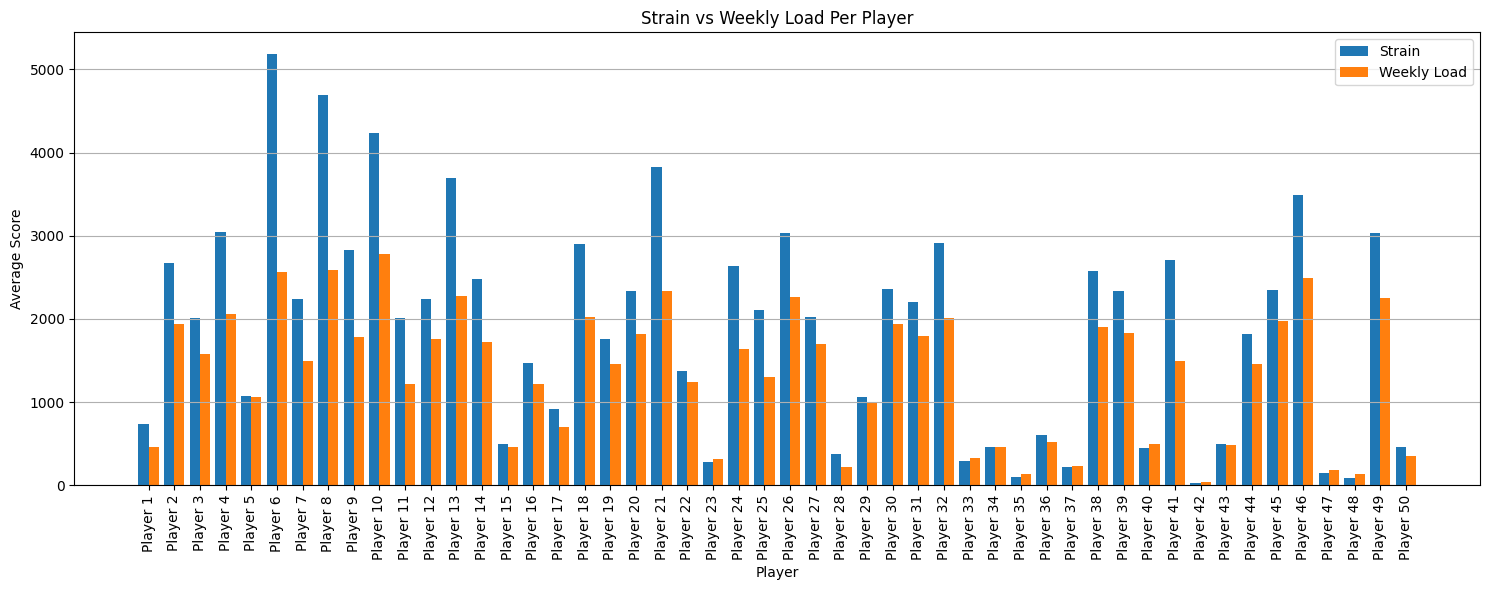

In [ ]:
bar_compare(strain_pd, weekly_pd, label1="Strain", label2="Weekly Load", title="Strain vs Weekly Load Per Player")


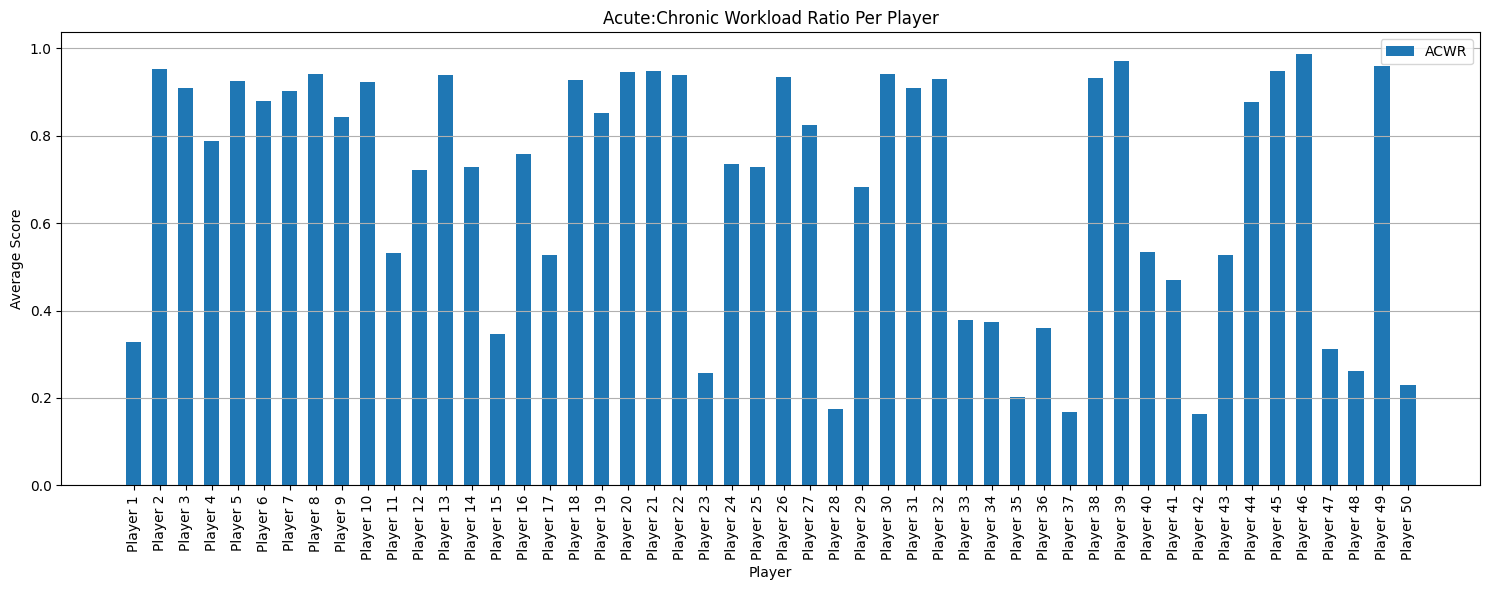

In [ ]:
# Plot 2: ACWR only
bar_compare(acwr_pd, label1="ACWR", title="Acute:Chronic Workload Ratio Per Player")


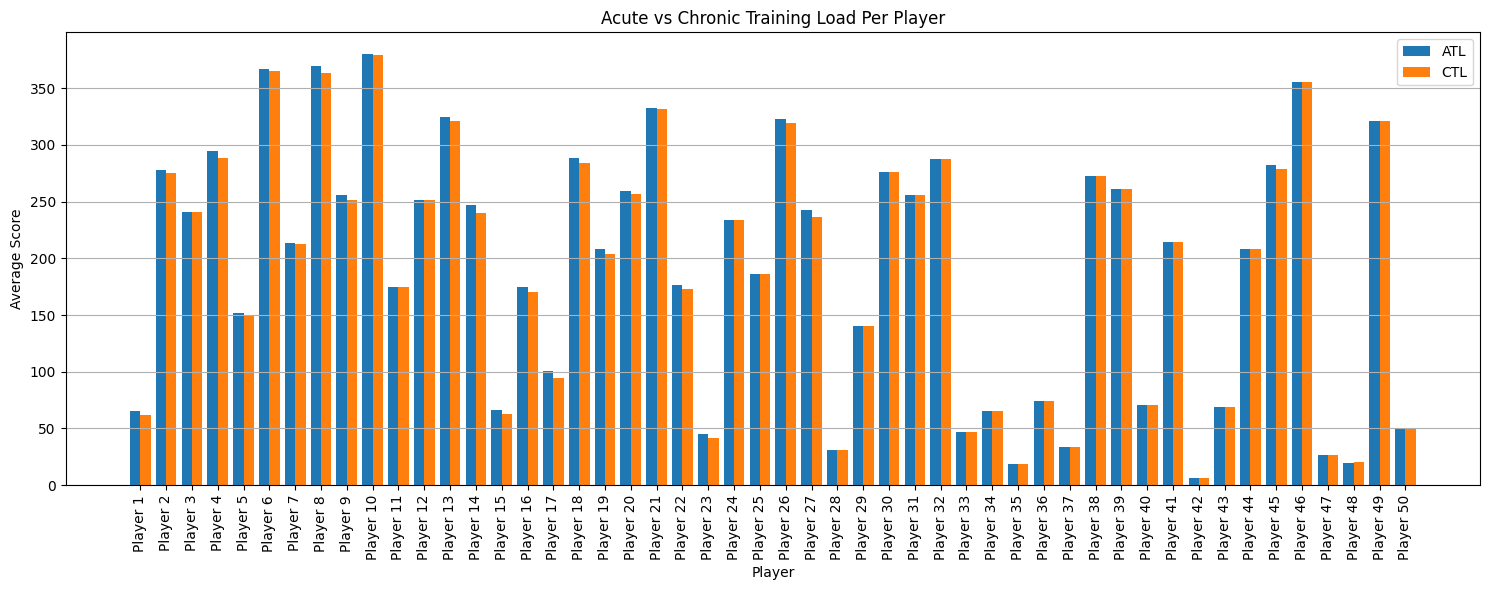

In [ ]:
# Plot 3: ATL vs CTL
bar_compare(actl_pd, ctl_pd, label1="ATL", label2="CTL", title="Acute vs Chronic Training Load Per Player")


# Now We Cluster And Use Elbow Method


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
!pip3 install kneed
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker


In [ ]:
def elbow_method(data, clustering_method, k_min, k_max, title):
    inertia = []
    k_values = list(range(k_min, k_max + 1))

    for k in k_values:
        kmeans = clustering_method(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    kneedle = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker="o", linestyle="--")
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
    plt.legend()
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title(title)
    plt.xticks(k_values)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return optimal_k


In [ ]:
def plot_cluster_histogram(df, value_col, k, title=None, bins=30):
    """
    Cluster the values in `value_col` using KMeans with k clusters,
    then plot a histogram of the actual values colored by cluster.

    Parameters:
    - df (pd.DataFrame): input DataFrame
    - value_col (str): name of the numeric column to cluster and plot
    - k (int): number of clusters (from elbow method)
    - title (str): plot title
    - bins (int): number of histogram bins
    - log_y (bool): whether to use log scale for y-axis
    """

    # Normalize the column for clustering
    X = StandardScaler().fit_transform(df[[value_col]])

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    df["cluster"] = kmeans.fit_predict(X)

    # Plot actual values, not normalized
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df,
        x=value_col,
        hue="cluster",
        bins=bins,
        kde=False,
        palette="tab10"
    )

    plt.title(title or f"{value_col} Distribution by Cluster")
    plt.xlabel(f"{value_col.replace('_', ' ').title()} (Actual Values)")
    plt.ylabel("Number of Players")

    # Format ticks
    plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{int(y)}'))

    # Remove grid
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Analyze Weekly Load

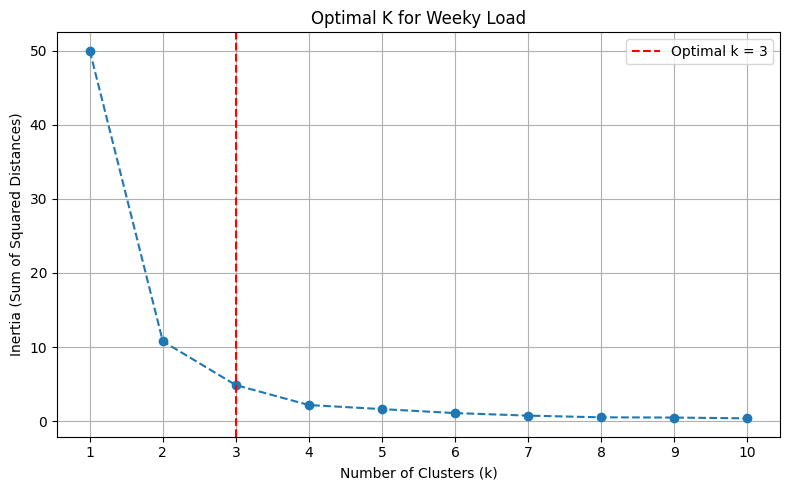

Optimal k for Weekly Load: 3


In [ ]:
# Step 1: Compute average scores per player
weekly_avg = weekly_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "weekly_load"})

# Step 2: Normalize
X_weekly = StandardScaler().fit_transform(weekly_avg[["weekly_load"]])

# Step 3: Run elbow method
optimal_k_weekly = elbow_method(X_weekly, KMeans, k_min=1, k_max=10, title="Optimal K for Weeky Load")
print(f"Optimal k for Weekly Load: {optimal_k_weekly}")


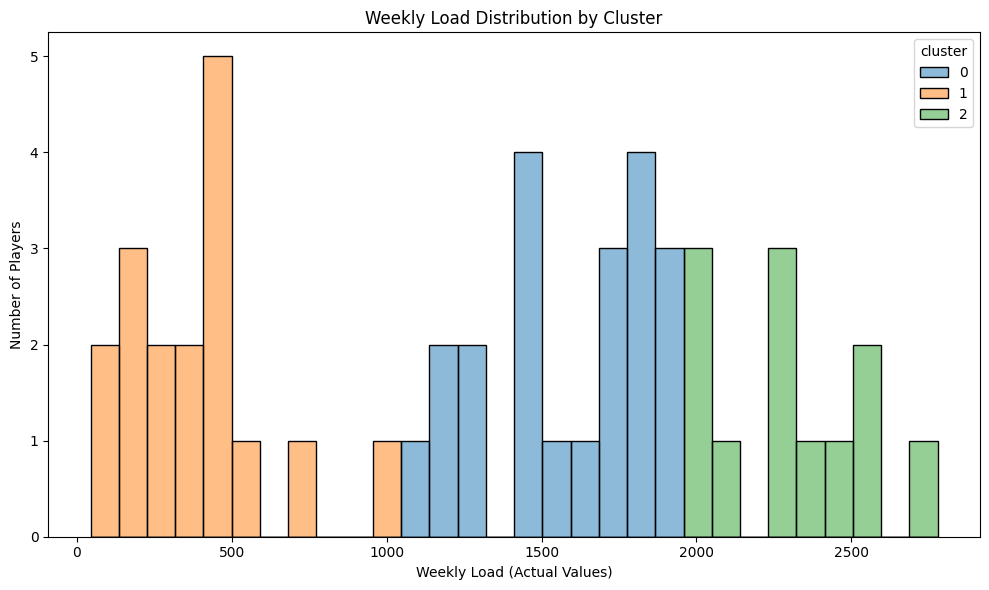

In [ ]:
plot_cluster_histogram(
    df=weekly_avg,
    value_col="weekly_load",
    k=optimal_k_weekly,
    title="Weekly Load Distribution by Cluster"
)

# Run Analysis on Daily Load

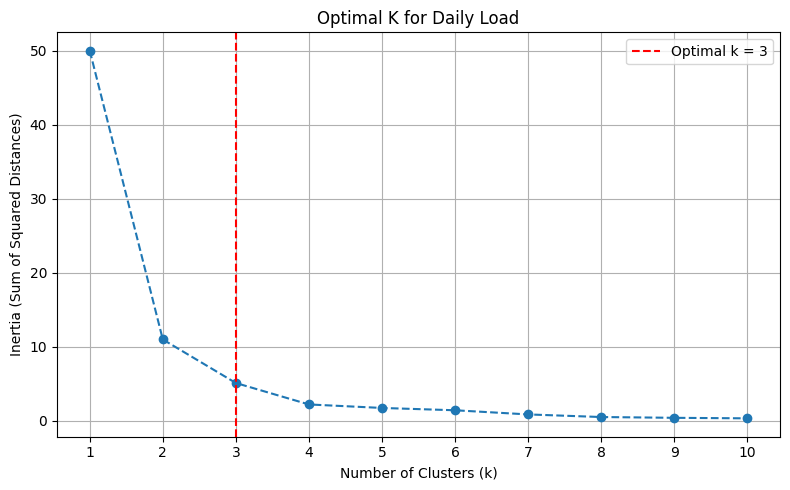

In [ ]:
# Step 1: Compute average scores per player
daily_avg = daily_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "daily_load"})

# Step 2: Normalize
X_daily = StandardScaler().fit_transform(daily_avg[["daily_load"]])

# Step 3: Run elbow method
optimal_k_daily= elbow_method(X_daily, KMeans, k_min=1, k_max=10, title="Optimal K for Daily Load")



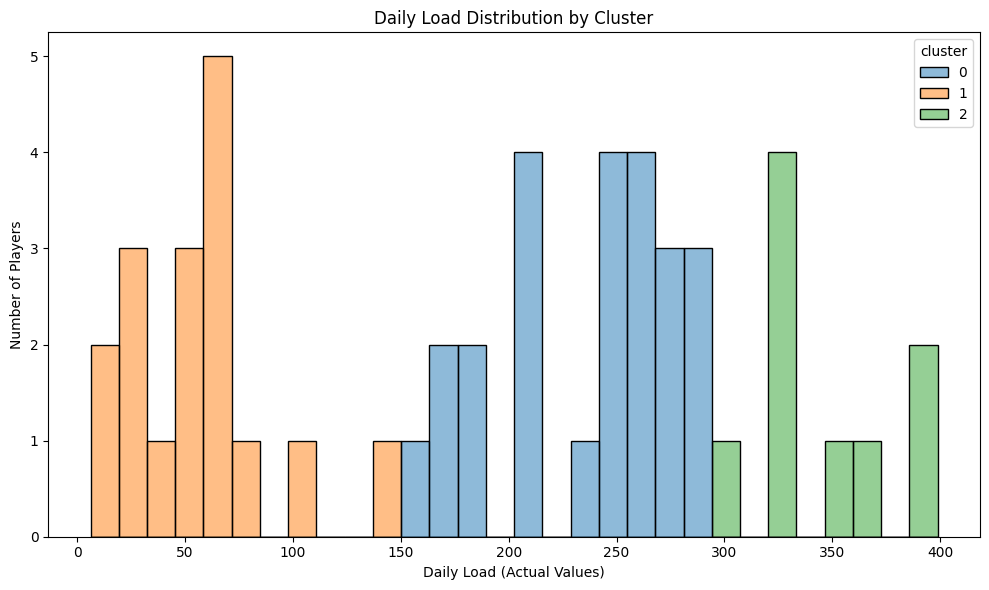

In [ ]:
plot_cluster_histogram(
    df=daily_avg,
    value_col="daily_load",
    k=optimal_k_daily,
    title="Daily Load Distribution by Cluster"
)

# Analyze Strain

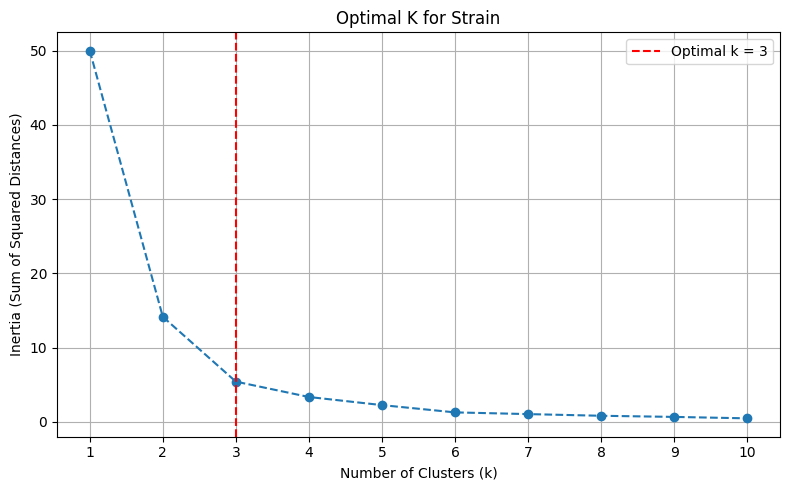

In [ ]:
# Step 1: Compute average scores per player
strain_avg = strain_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "strain"})

# Step 2: Normalize
X_strain = StandardScaler().fit_transform(strain_avg[["strain"]])

# Step 3: Run elbow method
optimal_k_strain= elbow_method(X_strain, KMeans, k_min=1, k_max=10, title="Optimal K for Strain")



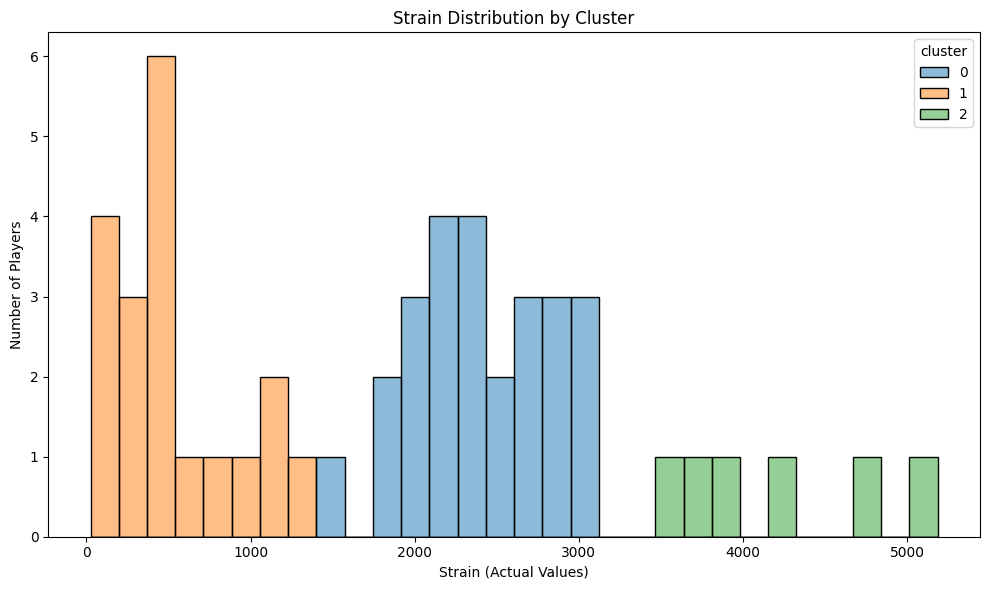

In [ ]:
plot_cluster_histogram(
    df=strain_avg,
    value_col="strain",
    k=optimal_k_strain,
    title="Strain Distribution by Cluster"
)

## This is where we extract the data from all of the wellness categories (e.g, sleep quality, readiness, etc.) and average them out to get an overall self-reported wellness score for each player.

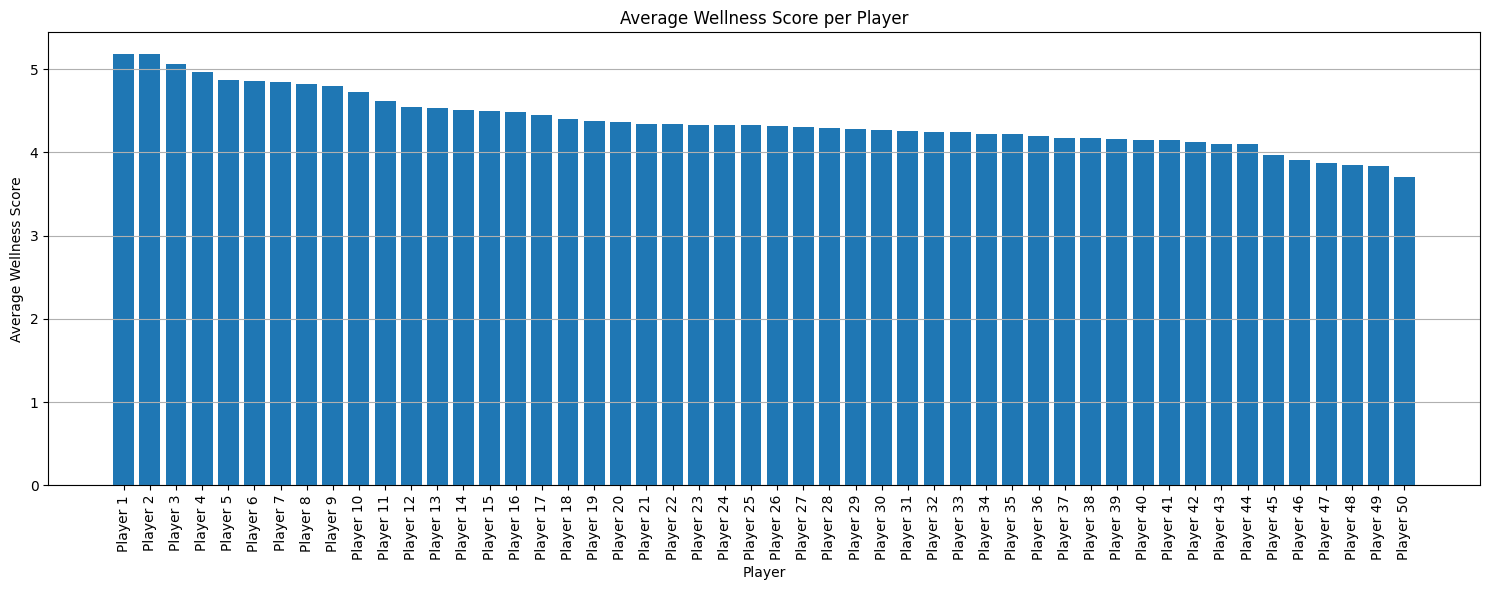

In [ ]:
# Path to folder with CSVs
data_dir = "/content/drive/MyDrive/cs426/subjective/wellness"

# Load and clean each CSV
category_scores = []
for filename in os.listdir(data_dir):
    path = os.path.join(data_dir, filename)

    # Read and skip the first row (it’s a broken header)
    df = pd.read_csv(path, skiprows=1)

    # Rename first column to 'date'
    df.rename(columns={df.columns[0]: 'date'}, inplace=True)

    # Melt to long format
    df_long = df.melt(id_vars='date', var_name='player_id', value_name='score')
    df_long['category'] = filename.replace(".csv", "")

    # Drop nulls and convert score to float
    df_long.dropna(subset=['score'], inplace=True)
    df_long['score'] = df_long['score'].astype(float)

    category_scores.append(df_long)

# Combine all categories
all_scores = pd.concat(category_scores)

# Compute wellness score by averaging scores per player per date
wellness_avg = all_scores.groupby(['date', 'player_id'])['score'].mean().reset_index(name='wellness_score')

# Final average wellness score per player
player_avg = wellness_avg.groupby('player_id')['wellness_score'].mean().reset_index()
player_avg = player_avg.sort_values(by='wellness_score', ascending=False)
player_avg['player_label'] = [f'Player {i+1}' for i in range(len(player_avg))]

# Plot
plt.figure(figsize=(15, 6))
plt.bar(player_avg['player_label'], player_avg['wellness_score'])
plt.xticks(rotation=90)
plt.xlabel("Player")
plt.ylabel("Average Wellness Score")
plt.title("Average Wellness Score per Player")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



Acute Chronic Workload Ratio & Weekly Load Comparison (Non-Subjective)

In [ ]:
acwr_avg = acwr_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "acwr"})

# Use elbow method manually or assume 3 clusters for low/medium/high wellness
kmeans = KMeans(n_clusters=3, random_state=42)
acwr_avg["cluster"] = kmeans.fit_predict(acwr_avg[["acwr"]])

# Merge features and labels
df = pd.merge(weekly_avg, acwr_avg, on="player_id")
df["healthy"] = df["acwr"].apply(lambda x: 1 if 0.8 <= x <= 1.3 else 0)
print(df)


                                     player_id  weekly_load  cluster_x  \
0   TeamA-0362cdd5-7a63-480a-a46a-62a99fb1692f   460.027374          1   
1   TeamA-2d44f941-2f24-4fc2-afa8-611a091f2e93  1943.857788          0   
2   TeamA-32fed4b3-d7fc-482d-ba21-c46c58f015b5  1582.339233          0   
3   TeamA-358603ef-b3a3-46b5-b80a-ad64e06b6592  2063.652588          2   
4   TeamA-3e5f6e2b-46b7-4890-84a9-3bbb2649af5a  1062.393921          0   
5   TeamA-4051bba7-1170-4c43-b912-8c38815a7625  2567.838623          2   
6   TeamA-560cb066-a8ae-412f-b09f-0d2a6aa0cf05  1494.801636          0   
7   TeamA-5a3be598-2f51-426f-95a5-b63d1d7c1b43  2584.562256          2   
8   TeamA-5a5b135d-d146-4b4c-b3da-efcd4d203f95  1788.071167          0   
9   TeamA-5cd7a61b-88b2-46d2-94f8-5a0d4f682d93  2778.932861          2   
10  TeamA-67961019-dbb5-464b-839e-08e5896c2c42  1220.068359          0   
11  TeamA-705923a2-378f-4f8e-8a29-464837b88cdc  1762.927490          0   
12  TeamA-74afe68c-f348-414c-9754-6d6f

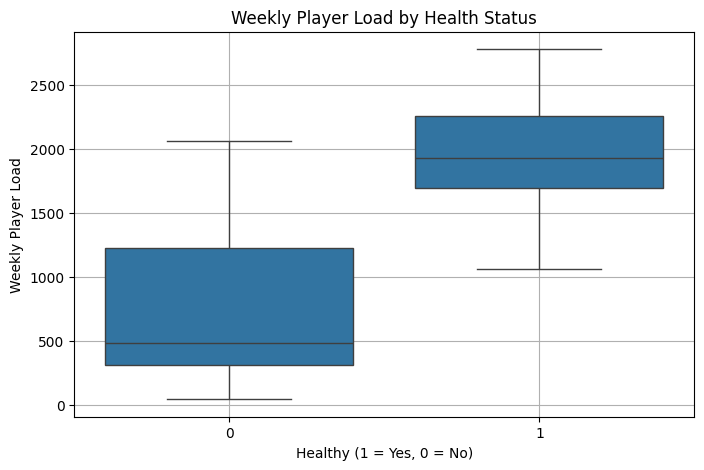

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="healthy", y="weekly_load", data=df)
plt.xlabel("Healthy (1 = Yes, 0 = No)")
plt.ylabel("Weekly Player Load")
plt.title("Weekly Player Load by Health Status")
plt.grid(True)
plt.show()


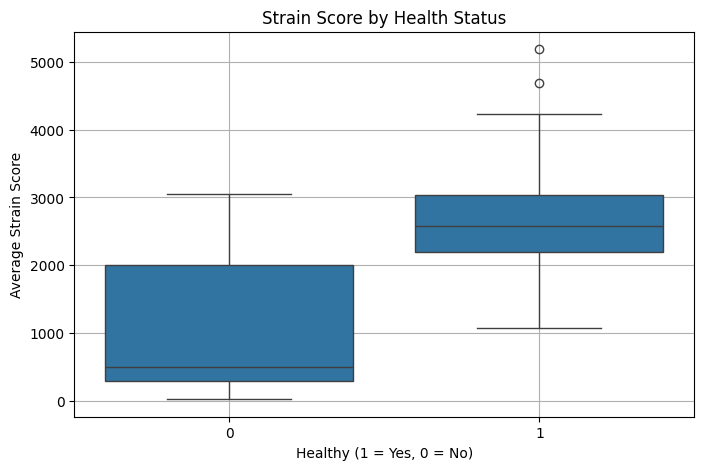

In [ ]:
# Step 1: Compute average strain score per player
strain_avg = strain_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "strain_score"})

# Step 2: Compute average ACWR per player (rename to 'acwr')
acwr_avg = acwr_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "acwr"})

# ✅ Renumber both independently
strain_avg["player_id"] = [f"Player {i+1}" for i in range(len(strain_avg))]
acwr_avg["player_id"] = [f"Player {i+1}" for i in range(len(acwr_avg))]

# Step 3: Cluster players by average strain
kmeans = KMeans(n_clusters=3, random_state=42)
strain_avg["cluster"] = kmeans.fit_predict(strain_avg[["strain_score"]])

# Step 4: Merge strain and ACWR data
df = pd.merge(strain_avg, acwr_avg, on="player_id")

# Step 5: Define health status based on ACWR thresholds
df["healthy"] = df["acwr"].apply(lambda x: 1 if 0.8 <= x <= 1.3 else 0)

# Step 6: Plot strain score vs health
plt.figure(figsize=(8, 5))
sns.boxplot(x="healthy", y="strain_score", data=df)
plt.xlabel("Healthy (1 = Yes, 0 = No)")
plt.ylabel("Average Strain Score")
plt.title("Strain Score by Health Status")
plt.grid(True)
plt.show()


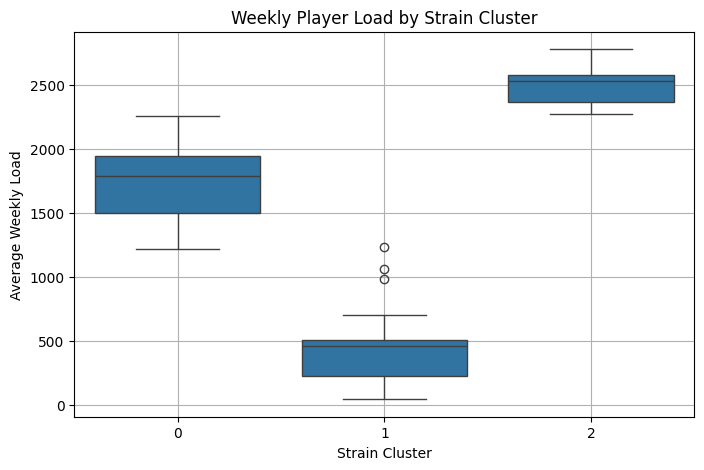

In [ ]:
# Step 1: Compute average weekly load per player
weekly_avg = weekly_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "weekly_load"})

# Step 2: Compute average strain score per player
strain_avg = strain_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "strain_score"})

# Renumber both
weekly_avg["player_id"] = [f"Player {i+1}" for i in range(len(weekly_avg))]
strain_avg["player_id"] = [f"Player {i+1}" for i in range(len(strain_avg))]

# Step 3: Cluster players by strain score
kmeans = KMeans(n_clusters=3, random_state=42)
strain_avg["cluster"] = kmeans.fit_predict(strain_avg[["strain_score"]])

# Step 4: Merge weekly load and strain
df = pd.merge(weekly_avg, strain_avg, on="player_id")
# Step 5: Plot weekly load vs strain cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x="cluster", y="weekly_load", data=df)
plt.xlabel("Strain Cluster")
plt.ylabel("Average Weekly Load")
plt.title("Weekly Player Load by Strain Cluster")
plt.grid(True)
plt.show()


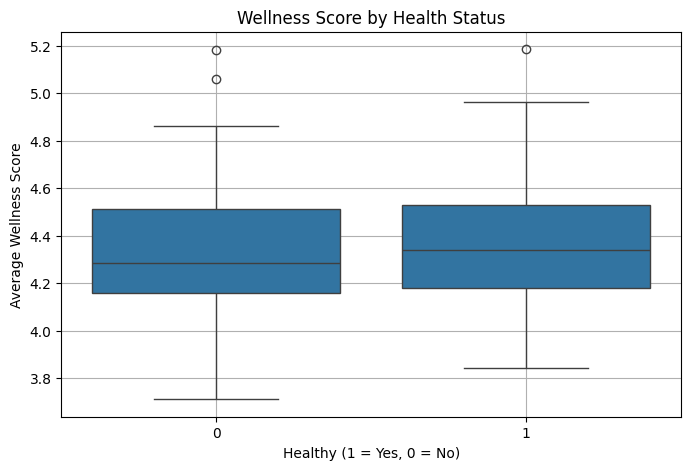

In [ ]:
# Step 1: Compute average wellness score per player
wellness_avg = wellness_avg.groupby("player_id")["wellness_score"].mean().reset_index()

# Step 2: Compute average ACWR per player (rename to 'acwr')
acwr_avg = acwr_pd.groupby("player_id")["score"].mean().reset_index().rename(columns={"score": "acwr"})

wellness_avg["player_id"] = [f"Player {i+1}" for i in range(len(wellness_avg))]
acwr_avg["player_id"] = [f"Player {i+1}" for i in range(len(acwr_avg))]

# Step 3: Cluster players by average wellness
kmeans = KMeans(n_clusters=3, random_state=42)
wellness_avg["cluster"] = kmeans.fit_predict(wellness_avg[["wellness_score"]])

# Step 4: Merge wellness and ACWR data
df = pd.merge(wellness_avg, acwr_avg, on="player_id")

# Step 5: Define health status based on ACWR thresholds
df["healthy"] = df["acwr"].apply(lambda x: 1 if 0.8 <= x <= 1.3 else 0)

# Step 6: Plot wellness score vs health
plt.figure(figsize=(8, 5))
sns.boxplot(x="healthy", y="wellness_score", data=df)
plt.xlabel("Healthy (1 = Yes, 0 = No)")
plt.ylabel("Average Wellness Score")
plt.title("Wellness Score by Health Status")
plt.grid(True)
plt.show()

### Classification Task for Acute Chronic Work Load and Self-Reported Wellness Score


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.83      0.71      0.77         7

    accuracy                           0.70        10
   macro avg       0.67      0.69      0.67        10
weighted avg       0.73      0.70      0.71        10


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.86      0.86      0.86         7

    accuracy                           0.80        10
   macro avg       0.76      0.76      0.76        10
weighted avg       0.80      0.80      0.80        10


Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      1.00      0.93         7

    accuracy                           0.90       

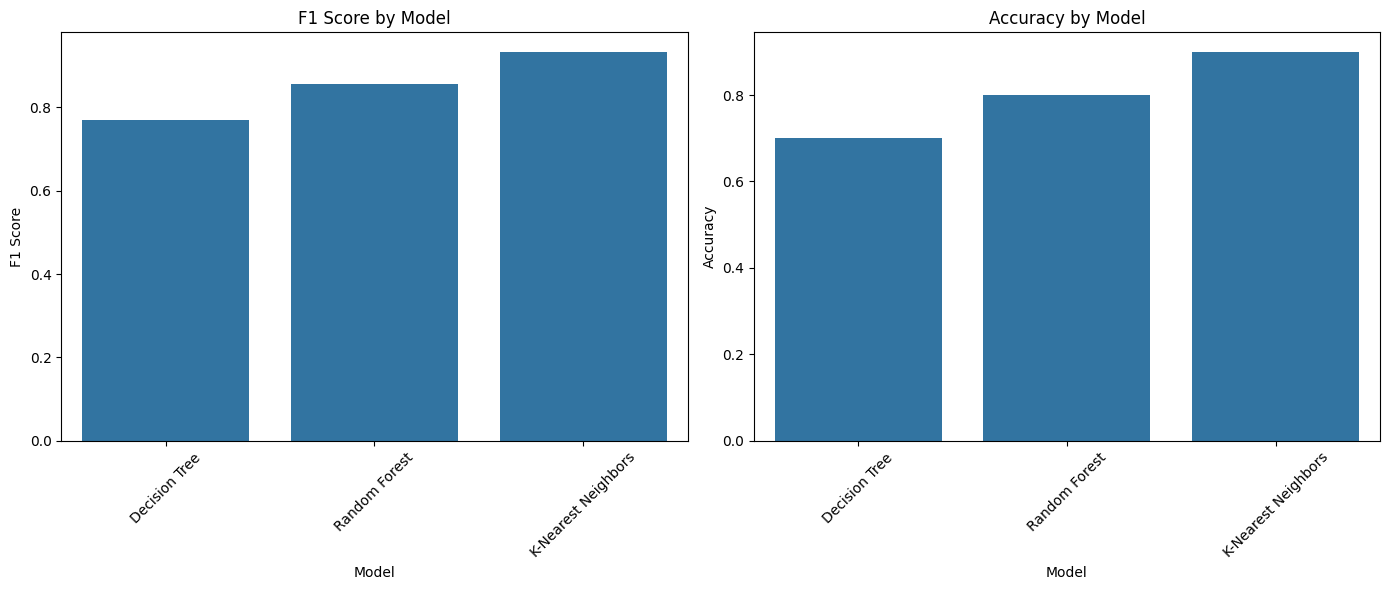

In [ ]:
# Healthy = 1 if ACWR is in 0.8–1.3 range, otherwise 0
df["healthy"] = df["acwr"].apply(lambda x: 1 if 0.8 <= x <= 1.3 else 0)
df = pd.merge(df, strain_avg[["player_id", "strain_score"]], on="player_id")
# --- : Define features and label ---
X = df[["wellness_score", "strain_score"]]
y = df["healthy"]
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
}

# Train, predict, and evaluate
results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\nClassification Report for {name}:\n{report}")

    results.append({
        "Model": name,
        "F1 Score": f1,
        "Accuracy": accuracy
    })

# Display and Visualize Results
results_df = pd.DataFrame(results)
print("\n🧾 Summary Table:\n", results_df)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
metrics = ["F1 Score", "Accuracy"]

for i, metric in enumerate(metrics):
    sns.barplot(data=results_df, x="Model", y=metric, ax=axes[i])
    axes[i].set_title(f"{metric} by Model")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Shows confusion matrix for classification task

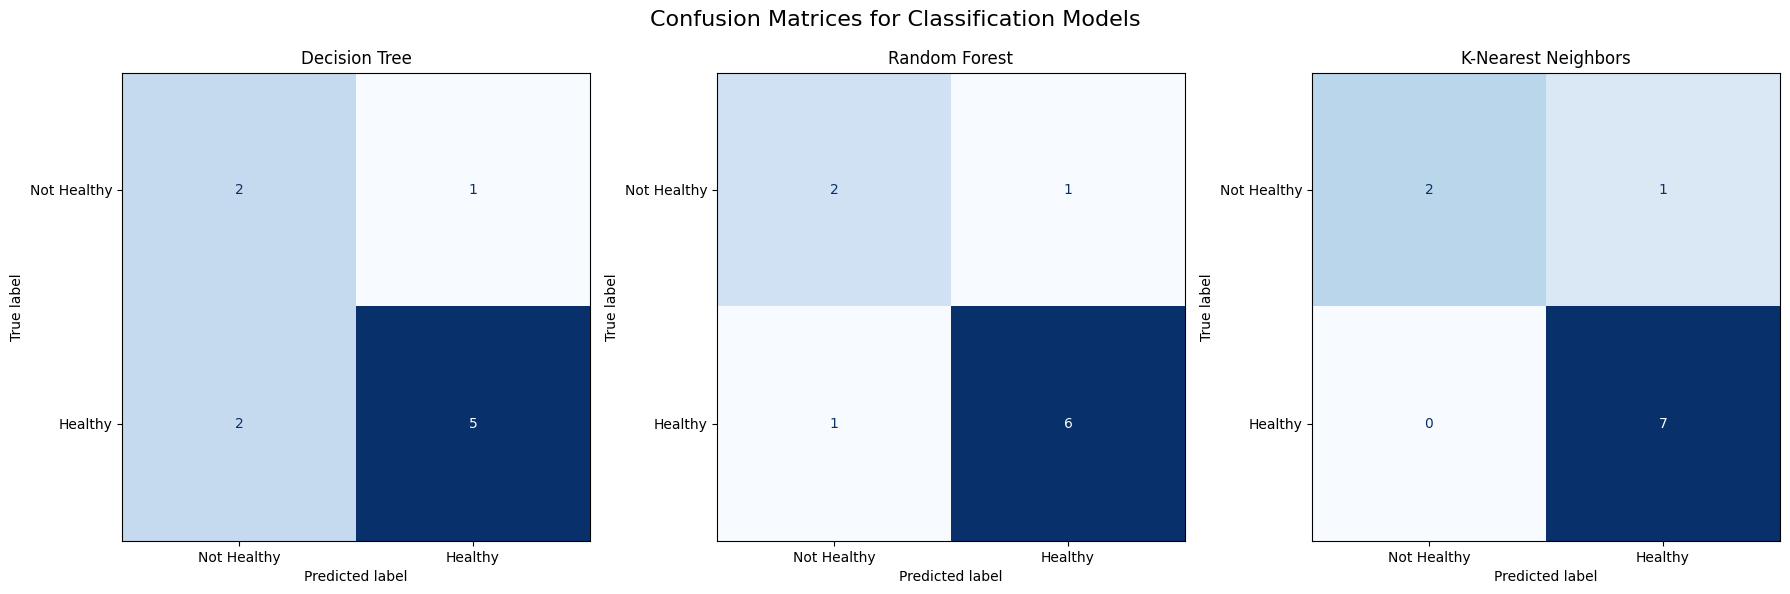

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1)
}

# Train models and store predictions
y_preds = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_preds[name] = model.predict(x_test)

class_labels = ["Not Healthy", "Healthy"]

# Plot confusion matrices side by side
fig, axes = plt.subplots(1, len(models), figsize=(18, 6))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(y_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', ax=axes[idx], colorbar=False)
    axes[idx].set_title(f"{name}")

plt.suptitle("Confusion Matrices for Classification Models", fontsize=16)
plt.tight_layout()
plt.show()

This code analyses the performance between classes

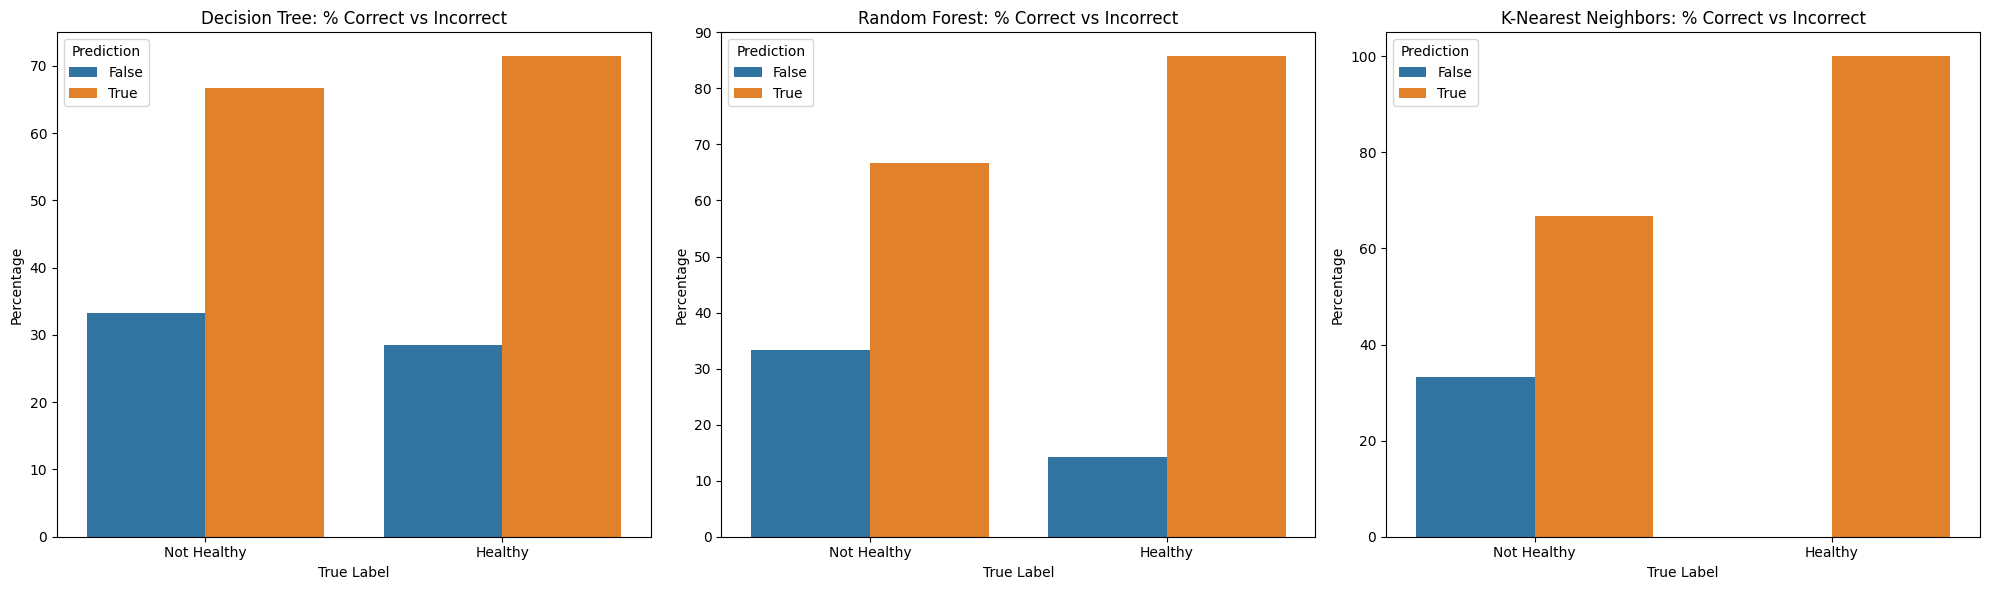

In [ ]:
fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
axes = axes.flatten()

label_map = {0: "Not Healthy", 1: "Healthy"}

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]

    # Fit model and predict
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # DataFrame of predictions
    errors = pd.DataFrame({
        "True Label": y_test,
        "Predicted Label": y_pred
    })
    errors["Correct"] = errors["True Label"] == errors["Predicted Label"]

    # Calculate percent correct/incorrect per class
    summary = (
        errors
        .groupby(["True Label", "Correct"])
        .size()
        .reset_index(name="count")
    )

    # Normalize to percent
    total_per_class = summary.groupby("True Label")["count"].transform("sum")
    summary["percent"] = 100 * summary["count"] / total_per_class

    # Replace numeric labels with strings
    summary["True Label"] = summary["True Label"].map(label_map)

    # Plot as barplot
    sns.barplot(data=summary, x="True Label", y="percent", hue="Correct", ax=ax)
    ax.set_title(f"{name}: % Correct vs Incorrect")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("True Label")
    ax.legend(title="Prediction")

plt.tight_layout()
plt.show()


### Added more features to make the model more robust (instead of average wellness instead use full data from each category)


 Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.47      0.30      0.36      1393
           1       0.61      0.76      0.68      1994

    accuracy                           0.57      3387
   macro avg       0.54      0.53      0.52      3387
weighted avg       0.55      0.57      0.55      3387


 Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.48      0.24      0.32      1393
           1       0.61      0.81      0.69      1994

    accuracy                           0.58      3387
   macro avg       0.54      0.53      0.51      3387
weighted avg       0.55      0.58      0.54      3387


 Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.44      0.32      0.37      1393
           1       0.60      0.72      0.66      1994

    accuracy                           0.56    

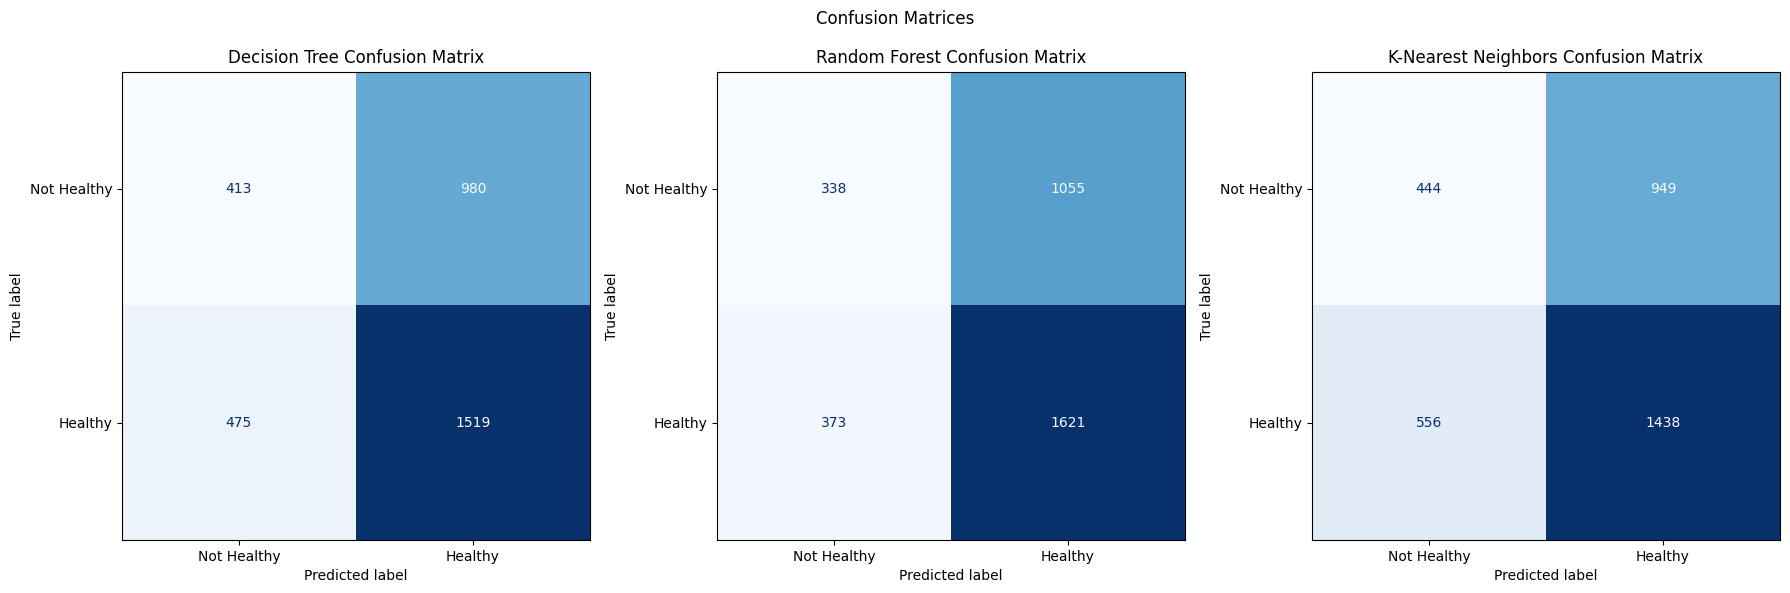


 Summary Table:
                  Model  Accuracy  F1 Score
0        Decision Tree  0.570416  0.676163
1        Random Forest  0.578388  0.694218
2  K-Nearest Neighbors  0.555654  0.656471


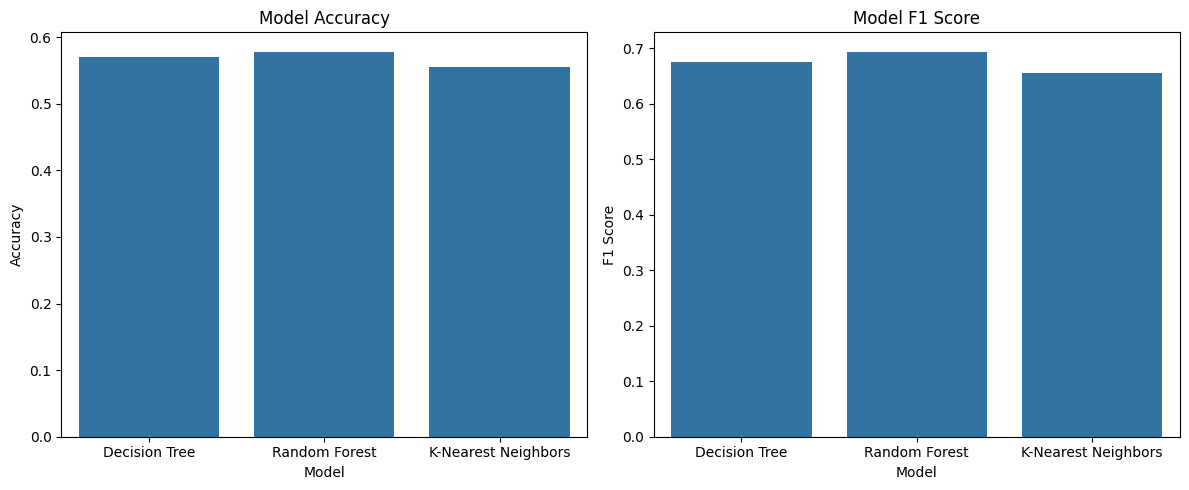

In [ ]:
# --- Load and clean all wellness CSVs ---
data_dir = "/content/drive/MyDrive/cs426/subjective/wellness"
category_dfs = []

for filename in os.listdir(data_dir):
    if not filename.endswith(".csv"):
        continue
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path)
    df.rename(columns={df.columns[0]: 'date'}, inplace=True)
    df_long = df.melt(id_vars='date', var_name='player_id', value_name='score')
    df_long['category'] = filename.replace(".csv", "")
    df_long.dropna(subset=['score'], inplace=True)
    df_long['score'] = df_long['score'].astype(float)
    category_dfs.append(df_long)

# Combine and pivot to wide format
all_long = pd.concat(category_dfs)
wellness_df = all_long.pivot_table(index=['date', 'player_id'], columns='category', values='score').reset_index()
wellness_df.dropna(inplace=True)

# --- Load and clean ACWR data (wide format to long) ---
acwr_df = pd.read_csv('/content/drive/MyDrive/cs426/subjective/training-load/acwr.csv')
acwr_df.rename(columns={'Date': 'date'}, inplace=True)
# Reshape ACWR to long format
acwr_long = acwr_df.melt(id_vars='date', var_name='player_id', value_name='acwr')
acwr_long['date'] = pd.to_datetime(acwr_long['date'], dayfirst=True, errors='coerce')
acwr_long.dropna(subset=['acwr'], inplace=True)
acwr_long['acwr'] = acwr_long['acwr'].astype(float)

# --- Align and merge wellness with ACWR ---
wellness_df['date'] = pd.to_datetime(wellness_df['date'], dayfirst=True, errors='coerce')
merged_df = pd.merge(wellness_df, acwr_long, on=['date', 'player_id'], how='inner')
merged_df.dropna(inplace=True)

# --- Create health label from ACWR threshold ---
merged_df['healthy'] = merged_df['acwr'].apply(lambda x: 1 if 0.8 <= x <= 1.3 else 0)

# --- Prepare features and label ---
X = merged_df.drop(columns=['date', 'player_id', 'acwr', 'healthy'])
y = merged_df['healthy']

# --- Train/test split ---
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Define and train models ---
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1)
}

results = []
fig, axes = plt.subplots(1, len(models), figsize=(18, 6))

for i, (name, model) in enumerate(models.items()):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})

    print(f"\n Classification Report for {name}:\n{classification_report(y_test, y_pred)}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Healthy", "Healthy"])
    disp.plot(cmap='Blues', ax=axes[i], colorbar=False)
    axes[i].set_title(f"{name} Confusion Matrix")

plt.suptitle("Confusion Matrices")
plt.tight_layout()
plt.show()

# --- Results Table ---
results_df = pd.DataFrame(results)
print("\n Summary Table:\n", results_df)

# --- Visualize Accuracy and F1 ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=results_df, x='Model', y='Accuracy', ax=axes[0])
axes[0].set_title('Model Accuracy')
sns.barplot(data=results_df, x='Model', y='F1 Score', ax=axes[1])
axes[1].set_title('Model F1 Score')
plt.tight_layout()
plt.show()



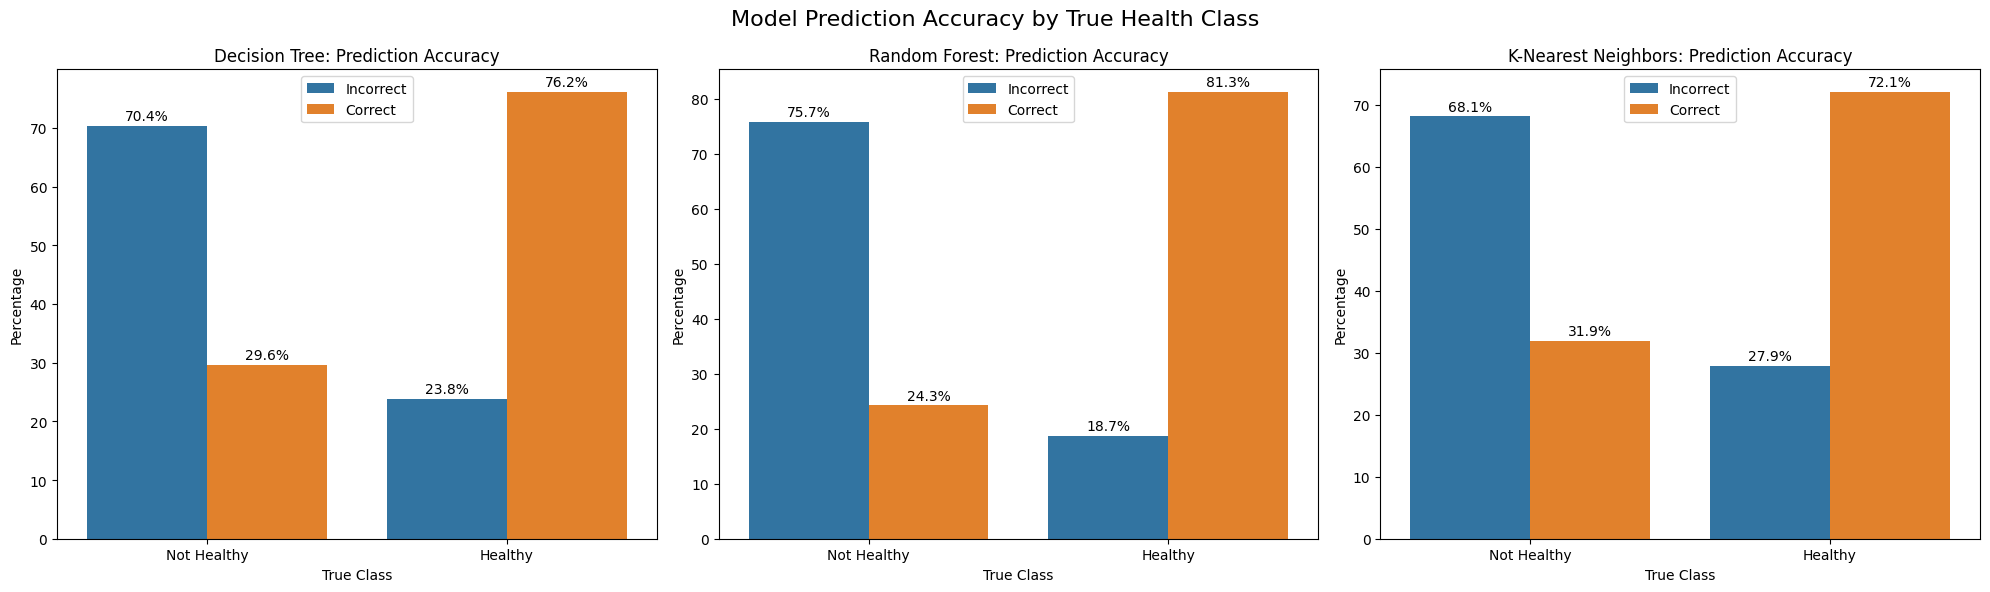

In [ ]:
fig, axes = plt.subplots(1, len(models), figsize=(20, 6))
axes = axes.flatten()

label_map = {0: "Not Healthy", 1: "Healthy"}

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]

    # Fit model and predict
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # DataFrame of predictions
    errors = pd.DataFrame({
        "True Label": y_test,
        "Predicted Label": y_pred
    })
    errors["Correct"] = errors["True Label"] == errors["Predicted Label"]

    # Count correct vs incorrect predictions per class
    summary = (
        errors
        .groupby(["True Label", "Correct"])
        .size()
        .reset_index(name="count")
    )

    # Normalize to percent within each true class
    summary["Total"] = summary.groupby("True Label")["count"].transform("sum")
    summary["Percent"] = 100 * summary["count"] / summary["Total"]

    # Replace numeric labels with descriptive strings
    summary["True Label"] = summary["True Label"].map(label_map)
    summary["Correct"] = summary["Correct"].map({True: "Correct", False: "Incorrect"})

    # Plot bar chart
    sns.barplot(data=summary, x="True Label", y="Percent", hue="Correct", ax=ax)
    ax.set_title(f"{name}: Prediction Accuracy")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("True Class")
    ax.legend(title="")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=2)

plt.suptitle("Model Prediction Accuracy by True Health Class", fontsize=16)
plt.tight_layout()
plt.show()
